# Import Required Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Reading the pickle files and combining it

In [3]:
data_folder = "data_collected"
all_data = []

for filename in os.listdir(data_folder):
    if filename.endswith(".pkl"):
        data = pd.read_pickle(os.path.join(data_folder, filename))
        all_data.append(data)

# Concatenate all dataframes into one
combined_data = pd.concat(all_data,ignore_index=True)

In [4]:
combined_data.head()

,front-end_ctn_latency,front-end_ctn_cpu,front-end_ctn_mem,front-end_ctn_net_in,front-end_ctn_net_out,user_ctn_latency,user_ctn_cpu,user_ctn_write,user_ctn_net_in,user_ctn_net_out,...,shipping_ctn_latency,shipping_ctn_cpu,shipping_ctn_net_in,shipping_ctn_net_out,catalogue_ctn_mem,shipping_ctn_mem,payment_ctn_mem,user_ctn_mem,orders_ctn_read,carts_ctn_read
0,0.000177,1.000000,1.000000,1.000000,1.000000,0.967725,0.919269,0.386220,0.988891,0.989757,...,0.000000,1.000000,0.967678,0.964468,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,1.000000,1.000000,0.799500,0.779866,0.887883,1.000000,0.386220,1.000000,1.000000,...,0.011570,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001359,0.961924,0.806594,0.937596,0.943102,0.949053,0.908910,0.441985,1.000000,1.000000,...,0.053329,0.959655,0.935266,0.928831,NaN,NaN,NaN,NaN,NaN,NaN
3,0.009961,0.890476,0.508149,0.937596,0.943102,1.000000,0.864126,0.441985,0.630091,0.627753,...,0.049957,0.960136,0.915968,0.918411,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020659,0.890476,0.508149,0.937596,0.943102,0.966232,0.813577,0.414229,0.680434,0.680339,...,0.014840,0.753303,0.915968,0.918411,NaN,NaN,NaN,NaN,NaN,NaN


# Data pre-processing and Root cause label using Anamoly detection

In [5]:
 combined_data.isnull().sum()

front-end_ctn_latency       0
front-end_ctn_cpu           0
front-end_ctn_mem           0
front-end_ctn_net_in        0
front-end_ctn_net_out       0
user_ctn_latency            0
user_ctn_cpu                0
user_ctn_write              0
user_ctn_net_in             0
user_ctn_net_out            0
catalogue_ctn_latency       0
catalogue_ctn_cpu           0
catalogue_ctn_net_in        0
catalogue_ctn_net_out       0
orders_ctn_latency          0
orders_ctn_cpu              0
orders_ctn_mem              0
orders_ctn_write            0
orders_ctn_net_in           0
orders_ctn_net_out          0
carts_ctn_latency           0
carts_ctn_cpu               0
carts_ctn_mem            1098
carts_ctn_write             0
carts_ctn_net_in            0
carts_ctn_net_out           0
payment_ctn_latency         0
payment_ctn_cpu             0
payment_ctn_net_in          0
payment_ctn_net_out         0
shipping_ctn_latency        0
shipping_ctn_cpu            0
shipping_ctn_net_in         0
shipping_c

In [6]:
combined_data.dropna(axis=1,inplace=True)

In [7]:
combined_data.head()

,front-end_ctn_latency,front-end_ctn_cpu,front-end_ctn_mem,front-end_ctn_net_in,front-end_ctn_net_out,user_ctn_latency,user_ctn_cpu,user_ctn_write,user_ctn_net_in,user_ctn_net_out,...,carts_ctn_net_in,carts_ctn_net_out,payment_ctn_latency,payment_ctn_cpu,payment_ctn_net_in,payment_ctn_net_out,shipping_ctn_latency,shipping_ctn_cpu,shipping_ctn_net_in,shipping_ctn_net_out
0,0.000177,1.000000,1.000000,1.000000,1.000000,0.967725,0.919269,0.386220,0.988891,0.989757,...,0.998661,0.998728,0.017280,1.000000,1.000000,1.000000,0.000000,1.000000,0.967678,0.964468
1,0.000000,1.000000,1.000000,0.799500,0.779866,0.887883,1.000000,0.386220,1.000000,1.000000,...,1.000000,1.000000,0.007289,0.881395,1.000000,1.000000,0.011570,1.000000,1.000000,1.000000
2,0.001359,0.961924,0.806594,0.937596,0.943102,0.949053,0.908910,0.441985,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.977455,0.890819,0.896963,0.053329,0.959655,0.935266,0.928831
3,0.009961,0.890476,0.508149,0.937596,0.943102,1.000000,0.864126,0.441985,0.630091,0.627753,...,0.807842,0.809256,0.004755,0.785657,0.890819,0.896963,0.049957,0.960136,0.915968,0.918411
4,0.020659,0.890476,0.508149,0.937596,0.943102,0.966232,0.813577,0.414229,0.680434,0.680339,...,0.792738,0.793640,0.021768,0.786972,0.890819,0.896963,0.014840,0.753303,0.915968,0.918411


In [8]:
combined_data.isnull().sum()

front-end_ctn_latency    0
front-end_ctn_cpu        0
front-end_ctn_mem        0
front-end_ctn_net_in     0
front-end_ctn_net_out    0
user_ctn_latency         0
user_ctn_cpu             0
user_ctn_write           0
user_ctn_net_in          0
user_ctn_net_out         0
catalogue_ctn_latency    0
catalogue_ctn_cpu        0
catalogue_ctn_net_in     0
catalogue_ctn_net_out    0
orders_ctn_latency       0
orders_ctn_cpu           0
orders_ctn_mem           0
orders_ctn_write         0
orders_ctn_net_in        0
orders_ctn_net_out       0
carts_ctn_latency        0
carts_ctn_cpu            0
carts_ctn_write          0
carts_ctn_net_in         0
carts_ctn_net_out        0
payment_ctn_latency      0
payment_ctn_cpu          0
payment_ctn_net_in       0
payment_ctn_net_out      0
shipping_ctn_latency     0
shipping_ctn_cpu         0
shipping_ctn_net_in      0
shipping_ctn_net_out     0
dtype: int64

In [9]:
combined_data.columns

Index(['front-end_ctn_latency', 'front-end_ctn_cpu', 'front-end_ctn_mem',
       'front-end_ctn_net_in', 'front-end_ctn_net_out', 'user_ctn_latency',
       'user_ctn_cpu', 'user_ctn_write', 'user_ctn_net_in', 'user_ctn_net_out',
       'catalogue_ctn_latency', 'catalogue_ctn_cpu', 'catalogue_ctn_net_in',
       'catalogue_ctn_net_out', 'orders_ctn_latency', 'orders_ctn_cpu',
       'orders_ctn_mem', 'orders_ctn_write', 'orders_ctn_net_in',
       'orders_ctn_net_out', 'carts_ctn_latency', 'carts_ctn_cpu',
       'carts_ctn_write', 'carts_ctn_net_in', 'carts_ctn_net_out',
       'payment_ctn_latency', 'payment_ctn_cpu', 'payment_ctn_net_in',
       'payment_ctn_net_out', 'shipping_ctn_latency', 'shipping_ctn_cpu',
       'shipping_ctn_net_in', 'shipping_ctn_net_out'],
      dtype='object')

In [10]:
# Function to calculate anomaly scores for each column
def calculate_anomaly_scores(data):
    # Standardize the data (Z-score)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Calculate anomaly scores using Isolation Forest
    anomaly_scores = IsolationForest().fit_predict(scaled_data)

    return anomaly_scores

# Function to calculate root cause probabilities
def calculate_root_cause_probabilities(anomaly_scores):
    root_cause_probabilities = 1.0 / (1.0 + np.exp(-anomaly_scores))
    return root_cause_probabilities

In [11]:
clf = IsolationForest(contamination=0.1)  # Adjust contamination as needed
outliers = clf.fit_predict(combined_data)

# Create the "root_cause" target column (1 for root_cause, 0 for not_root_cause)
combined_data['root_cause'] = (outliers == -1).astype(int)

In [12]:
combined_data.head(2)

,front-end_ctn_latency,front-end_ctn_cpu,front-end_ctn_mem,front-end_ctn_net_in,front-end_ctn_net_out,user_ctn_latency,user_ctn_cpu,user_ctn_write,user_ctn_net_in,user_ctn_net_out,...,carts_ctn_net_out,payment_ctn_latency,payment_ctn_cpu,payment_ctn_net_in,payment_ctn_net_out,shipping_ctn_latency,shipping_ctn_cpu,shipping_ctn_net_in,shipping_ctn_net_out,root_cause
0,0.000177,1.0,1.0,1.0000,1.000000,0.967725,0.919269,0.38622,0.988891,0.989757,...,0.998728,0.017280,1.000000,1.0,1.0,0.00000,1.0,0.967678,0.964468,1
1,0.000000,1.0,1.0,0.7995,0.779866,0.887883,1.000000,0.38622,1.000000,1.000000,...,1.000000,0.007289,0.881395,1.0,1.0,0.01157,1.0,1.000000,1.000000,1


In [13]:
combined_data['root_cause'].value_counts()

root_cause
0    1207
1     135
Name: count, dtype: int64

# Exploratory Data Analysis

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# Display basic statistics
print("Basic Statistics:")
print(combined_data.describe())

Basic Statistics:
       front-end_ctn_latency  front-end_ctn_cpu  front-end_ctn_mem  \
count            1342.000000        1342.000000        1342.000000   
mean                0.773415           0.382945           0.358970   
std                 0.321099           0.346638           0.276055   
min                 0.000000           0.000000           0.000000   
25%                 0.783955           0.050981           0.143031   
50%                 0.932083           0.270823           0.305891   
75%                 0.972527           0.654136           0.503893   
max                 1.000000           1.000000           1.000000   

       front-end_ctn_net_in  front-end_ctn_net_out  user_ctn_latency  \
count           1342.000000            1342.000000       1342.000000   
mean               0.346424               0.370371          0.557828   
std                0.319644               0.317893          0.322419   
min                0.000000               0.000000          0.0

# Data splitting

In [15]:
from sklearn.model_selection import train_test_split

X_preprocessed = combined_data.drop(columns=['root_cause'])
y = combined_data['root_cause']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Constructing the Graph

In [16]:
# Select features for anomaly detection (replace with your selected feature names)
selected_features = combined_data.columns.to_list()
# Exclude the 'root_cause' column
selected_features_no_label = [col for col in selected_features if col != 'root_cause']
# Create a function to convert tabular data to graphs
def create_graph_from_df(df):
    G = nx.Graph()
    for index, row in df.iterrows():
        node_features = row[selected_features_no_label].values
        G.add_node(index, features=node_features, label=row['root_cause'])
    return G

data_graph = create_graph_from_df(combined_data)

# Graph Visualisation

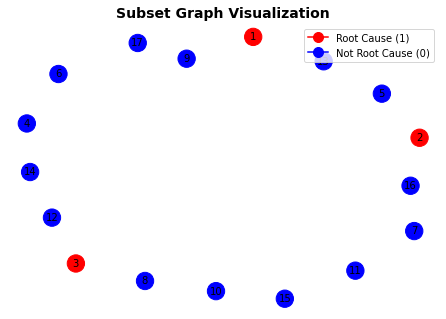

In [17]:
# Create a subset graph with 4 nodes (adjust the node IDs as needed)
subset_nodes = [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

# Create a new graph containing only the subset of nodes
subset_graph = data_graph.subgraph(subset_nodes)

# Define node colors based on the 'root_cause' label
node_colors = ['r' if subset_graph.nodes[node]['label'] == 1 else 'b' for node in subset_graph.nodes()]

# Visualize the subset graph
pos = nx.spring_layout(subset_graph, seed=42)
nx.draw(subset_graph, pos, node_color=node_colors, with_labels=True, node_size=300, font_size=10)

# Create a custom legend
red_patch = plt.Line2D([], [], color='red', marker='o', markersize=10, label='Root Cause (1)')
blue_patch = plt.Line2D([], [], color='blue', marker='o', markersize=10, label='Not Root Cause (0)')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')

# Add a title
plt.title("Subset Graph Visualization", fontsize=14, fontweight='bold')

plt.show()

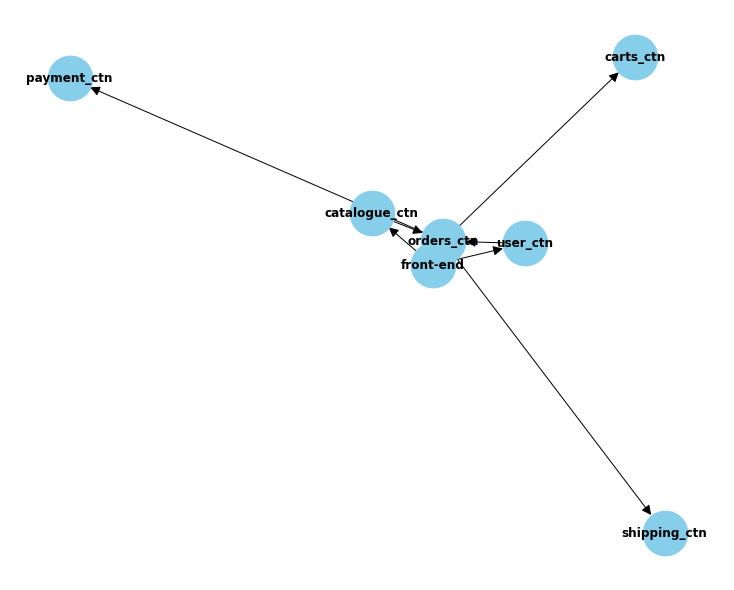

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the dependencies between microservices
dependencies = {
    'front-end': ['user_ctn', 'catalogue_ctn'],
    'user_ctn': ['orders_ctn'],
    'catalogue_ctn': ['orders_ctn'],
    'orders_ctn': ['carts_ctn', 'payment_ctn', 'shipping_ctn'],
    'carts_ctn': [],
    'payment_ctn': [],
    'shipping_ctn': []
}

# Create a directed graph
G = nx.DiGraph()

# Add nodes (microservices) to the graph
G.add_nodes_from(dependencies.keys())

# Add edges (dependencies) to the graph
for microservice, depends_on in dependencies.items():
    for dependency in depends_on:
        G.add_edge(microservice, dependency)

# Define node positions for visualization
pos = nx.spring_layout(G, seed=42)

# Create a larger figure
plt.figure(figsize=(10, 8))

# Draw the graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,  # Adjust the node size as needed
    node_color='skyblue',
    font_size=12,  # Increase font size
    font_color='black',
    font_weight='bold',
    arrowsize=20,
)

# Show the graph
plt.show()

# Data Loader

In [22]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# Create a DataLoader for training data
train_data = Data(x=X_train_tensor, y=y_train_tensor)
train_loader = DataLoader([train_data], batch_size=32, shuffle=True)

C:\Users\RGUKT\anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Definining the GNN Model Architecture

In [23]:
import torch.nn as nn

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training The GNN Model

In [24]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# Define your model and optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
model = GNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)  # Assuming X_train_tensor is a tensor of node features
    
    # Reshape y_train_tensor to match the shape of output
    y_train_tensor = y_train_tensor.view(-1, 1)
    
    loss = F.binary_cross_entropy_with_logits(output, y_train_tensor)  # Binary Cross-Entropy Loss
    loss.backward()
    optimizer.step()
    
    # Print epoch progress
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished!')

Epoch [1/300], Loss: 0.7356
Epoch [2/300], Loss: 0.6247
Epoch [3/300], Loss: 0.5429
Epoch [4/300], Loss: 0.4926
Epoch [5/300], Loss: 0.4674
Epoch [6/300], Loss: 0.4497
Epoch [7/300], Loss: 0.4293
Epoch [8/300], Loss: 0.4038
Epoch [9/300], Loss: 0.3745
Epoch [10/300], Loss: 0.3436
Epoch [11/300], Loss: 0.3140
Epoch [12/300], Loss: 0.2877
Epoch [13/300], Loss: 0.2656
Epoch [14/300], Loss: 0.2477
Epoch [15/300], Loss: 0.2338
Epoch [16/300], Loss: 0.2227
Epoch [17/300], Loss: 0.2132
Epoch [18/300], Loss: 0.2047
Epoch [19/300], Loss: 0.1972
Epoch [20/300], Loss: 0.1912
Epoch [21/300], Loss: 0.1868
Epoch [22/300], Loss: 0.1838
Epoch [23/300], Loss: 0.1815
Epoch [24/300], Loss: 0.1797
Epoch [25/300], Loss: 0.1784
Epoch [26/300], Loss: 0.1773
Epoch [27/300], Loss: 0.1766
Epoch [28/300], Loss: 0.1762
Epoch [29/300], Loss: 0.1759
Epoch [30/300], Loss: 0.1758
Epoch [31/300], Loss: 0.1755
Epoch [32/300], Loss: 0.1751
Epoch [33/300], Loss: 0.1747
Epoch [34/300], Loss: 0.1742
Epoch [35/300], Loss: 0

Epoch [285/300], Loss: 0.1191
Epoch [286/300], Loss: 0.1191
Epoch [287/300], Loss: 0.1190
Epoch [288/300], Loss: 0.1189
Epoch [289/300], Loss: 0.1187
Epoch [290/300], Loss: 0.1186
Epoch [291/300], Loss: 0.1186
Epoch [292/300], Loss: 0.1183
Epoch [293/300], Loss: 0.1184
Epoch [294/300], Loss: 0.1181
Epoch [295/300], Loss: 0.1180
Epoch [296/300], Loss: 0.1178
Epoch [297/300], Loss: 0.1178
Epoch [298/300], Loss: 0.1177
Epoch [299/300], Loss: 0.1175
Epoch [300/300], Loss: 0.1173
Training finished!


In [25]:
import torch

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract the values from the DataFrame
X_test_values = X_test.values

# Convert the values to a PyTorch tensor
X_test_tensor = torch.tensor(X_test_values, dtype=torch.float32)


X_test_tensor = X_test_tensor.to(device)  


# Model Evaluation

In [26]:
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)  # Assuming X_test_tensor is a tensor of test node features
    predicted_labels = (test_output > 0.5).float()  # Binary classification threshold

Accuracy: 0.9294
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       250
         1.0       0.50      0.53      0.51        19

    accuracy                           0.93       269
   macro avg       0.73      0.74      0.74       269
weighted avg       0.93      0.93      0.93       269



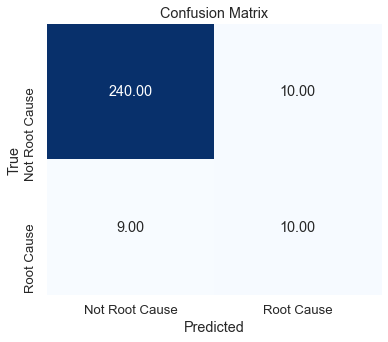

In [27]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'y_test' is a Pandas Series containing your ground truth labels
# Convert 'y_test' to a NumPy array
y_test_np = y_test.to_numpy()

# Convert 'y_test_np' to a PyTorch tensor
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

# Ensure that 'y_test_tensor' is on the same device as your model if using GPU
y_test_tensor = y_test_tensor.to(device)  # Replace 'device' with your actual device if using GPU


# Evaluate the model and compute predicted labels
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)  # Assuming X_test_tensor is a tensor of test node features
    predicted_labels = (test_output > 0.5).float()  # Binary classification threshold

# Convert 'y_test_tensor' and 'predicted_labels' to NumPy arrays for sklearn metrics
y_test_np = y_test_tensor.cpu().numpy()
predicted_labels_np = predicted_labels.cpu().numpy()

# Compute accuracy
accuracy = accuracy_score(y_test_np, predicted_labels_np)
print(f"Accuracy: {accuracy:.4f}")

# Generate a classification report
classification_rep = classification_report(y_test_np, predicted_labels_np)

# Print the classification report
print("Classification Report:")
print(classification_rep)

# Create a confusion matrix
confusion_matrix = np.zeros((2, 2))  # Assuming binary classification
for i in range(len(y_test_np)):
    confusion_matrix[int(y_test_np[i])][int(predicted_labels_np[i])] += 1

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False, 
            xticklabels=["Not Root Cause", "Root Cause"],
            yticklabels=["Not Root Cause", "Root Cause"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Making prediction of Root cause localisation of Microservice

In [28]:
import pandas as pd
import numpy as np
import joblib  # For loading the pre-trained model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


# Function to predict root cause and identify contributing columns
def predict_root_cause(new_data):
    # Define the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extract the values from the DataFrame
    new_data_values = new_data.values

    # Convert the values to a PyTorch tensor
    new_data_tensor = torch.tensor(new_data_values, dtype=torch.float32)

    # Ensure that X_test_tensor is on the same device as your model if using GPU
    new_data_tensor = new_data_tensor.to(device)  # Replace 'device' with your actual device if using GPU
    
    # Evaluate the model and compute predicted labels
    model.eval()
    with torch.no_grad():
        test_output = model(new_data_tensor)  # Assuming X_test_tensor is a tensor of test node features
        predictions = (test_output > 0.5).float()  # Binary classification threshold

    return predictions

In [132]:
# Function to identify the most influential column for a given prediction
def identify_most_influential_column(model, data):
    # Set the model to evaluation mode
    model.eval()

    # Create a PyTorch tensor for the input data
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)

    # Forward pass to compute node importance scores
    with torch.no_grad():
        node_importance_scores = model(data_tensor)
        node_importance_scores = torch.relu(node_importance_scores)

    # Calculate the importance score for each column
    column_importance_scores = node_importance_scores.mean(dim=0)

    # Find the column index with the highest importance score
    most_influential_column_index = column_importance_scores.argmax().item()

    # Get the corresponding column name
    most_influential_column = data.columns[most_influential_column_index]

    return most_influential_column



# Prepare the data
data = {
    'front-end_ctn_latency': [0.896903],
    'front-end_ctn_cpu': [0.986019],
    'front-end_ctn_mem': [0.351391],
    'front-end_ctn_net_in': [0.917039],
    'front-end_ctn_net_out': [0.059639],
    'user_ctn_latency': [0.349035],
    'user_ctn_cpu': [0.972092],
    'user_ctn_write': [0.470203],
    'user_ctn_net_in': [0.501294],
    'user_ctn_net_out': [0.948293],
    'catalogue_ctn_latency': [0.432175],
    'catalogue_ctn_cpu': [0.825641],
    'catalogue_ctn_net_in': [0.753215],
    'catalogue_ctn_net_out': [0.167839],
    'orders_ctn_latency': [0.278429],
    'orders_ctn_cpu': [0.631357],
    'orders_ctn_mem': [0.235916],
    'orders_ctn_write': [0.678193],
    'orders_ctn_net_in': [0.732049],
    'orders_ctn_net_out': [0.109237],
    'carts_ctn_latency': [0.543287],
    'carts_ctn_cpu': [0.427694],
    'carts_ctn_write': [0.890124],
    'carts_ctn_net_in': [0.621709],
    'carts_ctn_net_out': [0.395128],
    'payment_ctn_latency': [0.646105],
    'payment_ctn_cpu': [0.717882],
    'payment_ctn_net_in': [0.485509],
    'payment_ctn_net_out': [0.249117],
    'shipping_ctn_latency': [0.733452],
    'shipping_ctn_cpu': [0.196768],
    'shipping_ctn_net_in': [0.409398],
    'shipping_ctn_net_out': [0.533352]
}


# Create a DataFrame from the provided data
new_data = pd.DataFrame(data)

# Make predictions using your model (replace 'model' with your actual model)
predictions = predict_root_cause(new_data)

# Check if a root cause is predicted
if predictions == 1:
    # Identify the most influential column (replace 'model' with your actual model)
    most_influential_column = identify_most_influential_column(model, new_data)
    root_cause = "Root Cause"
else:
    root_cause = "No Root Cause"
    most_influential_column = None

# Display the results
print(new_data)
print("Root Cause:", root_cause)
if root_cause == "Root Cause":
    print("Most Influential Column:", most_influential_column)

   front-end_ctn_latency  front-end_ctn_cpu  front-end_ctn_mem  \
0               0.896903           0.986019           0.351391   

   front-end_ctn_net_in  front-end_ctn_net_out  user_ctn_latency  \
0              0.917039               0.059639          0.349035   

   user_ctn_cpu  user_ctn_write  user_ctn_net_in  user_ctn_net_out  ...  \
0      0.972092        0.470203         0.501294          0.948293  ...   

   carts_ctn_net_in  carts_ctn_net_out  payment_ctn_latency  payment_ctn_cpu  \
0          0.621709           0.395128             0.646105         0.717882   

   payment_ctn_net_in  payment_ctn_net_out  shipping_ctn_latency  \
0            0.485509             0.249117              0.733452   

   shipping_ctn_cpu  shipping_ctn_net_in  shipping_ctn_net_out  
0          0.196768             0.409398              0.533352  

[1 rows x 33 columns]
Root Cause: Root Cause
Most Influential Column: front-end_ctn_latency
